In [64]:
!pip install opencv-python
!pip install opencv-contrib-python
!pip install imblearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.0/258.0 KB 4.9 MB/s eta 0:00:00a 0:00:01


In [94]:
import cv2
from PIL import Image
import numpy as np
import zipfile
import os
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import  accuracy_score

In [15]:
imagem = cv2.imread('/home/nunesfi/Desktop/IA/files/Imagens-20230825T013751Z-001/Imagens/workplace-1245776_1920.jpg')
#cv2.imshow('img', imagem)

In [16]:
#modelo pre-treinado
detector_face = cv2.CascadeClassifier('/home/nunesfi/Desktop/IA/files/Cascades OpenCV-20230825T013817Z-001/Cascades OpenCV/haarcascade_frontalface_default.xml')

In [17]:
#escala de cinza
imagem_cinza = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)

In [18]:
#modelo cascade, imagem, fator de scala e tamanho mínimo da face detectada
deteccoes = detector_face.detectMultiScale(imagem_cinza, scaleFactor=1.3, minSize=(30,30))

In [19]:
len(deteccoes)

5

In [20]:
#fazendo anotação da caixas na imagem original
for (x, y, l, a) in deteccoes:
    #fazendo o retangulo nas detecções + destacando com a cor verde
    cv2.rectangle(imagem, (x,y), (x + l, y + a), (0,255,0), 2)

## Reconhecimento facial

In [22]:
path = '/home/nunesfi/Desktop/IA/files/Bases de dados-20230823T013645Z-001/Bases de dados/yalefaces.zip'
zip_object = zipfile.ZipFile(file=path,mode='r')
zip_object.extractall('./')
zip_object.close()

In [33]:
def dados_imagem():
    caminhos = [os.path.join('/home/nunesfi/Desktop/IA/project/Visao_computacional/yalefaces/train', f) for f in os.listdir('/home/nunesfi/Desktop/IA/project/Visao_computacional/yalefaces/train')]
    faces = []
    ids = []
    for caminho in caminhos:
        #Usar somente 1 canal (escala de cinza)
        imagem = Image.open(caminho).convert("L")
        #criar imagem no formato do numpy
        imagem_np = np.array(imagem, "uint8")
        id = int(os.path.split(caminho)[1].split('.')[0].replace("subject", ''))
        ids.append(id)
        faces.append(imagem_np)
    return np.array(ids), faces


In [34]:
ids, faces = dados_imagem()

In [35]:
print(ids)

[ 1 15 12 10 14 15 11 11  2  8 15  4 14  5  2  6 13 12  8  5  5 11 15  6
  4 12  9  9  3  5  2 12 13  5 10  5 11  6 14 10  5  1  3  6 13  3  8  3
  9  9 11  3  9  3  8  7  2 13 13 13  7  4 13  8 10  4  1 14  7 15 11 14
  4 12 11  7 12  1  8  1  5 10  7  3  7  9 10  8  7  6  1 11  4  7  3  6
 12 13  8 14 10 14 10 15  2  9  6  3  6 12  9 12  8 13  5  2 15  1 10  2
 11  4  6  2  4  4 14 15 14  1  7  2  1 15  9]


In [46]:
lbph = cv2.face.LBPHFaceRecognizer_create()
lbph.train(faces, ids)
lbph.write('classificadorLBPH.yml')

AttributeError: module 'cv2' has no attribute 'face'

## Dados desbalanceados

In [48]:
#Preparação dos dados
base_census = pd.read_csv('/home/nunesfi/Desktop/IA/files/Bases de dados-20230823T013645Z-001/Bases de dados/census.csv')

In [52]:
# Contagem de dados por classe
np.unique(base_census['income'], return_counts = True)

(array([' <=50K', ' >50K'], dtype=object), array([24720,  7841]))

<Axes: xlabel='income', ylabel='count'>

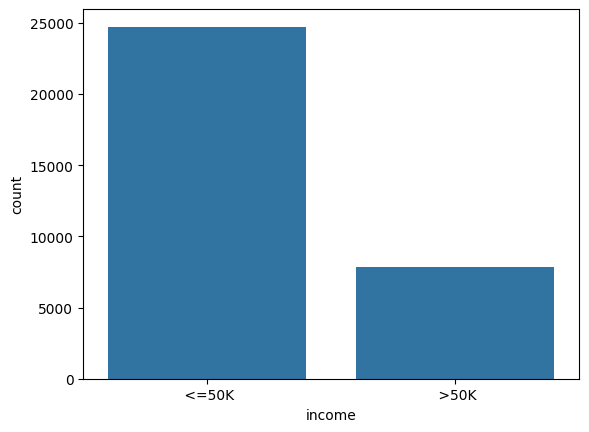

In [54]:
sns.countplot(x= base_census['income'])

In [55]:
x_census = base_census.iloc[:,0:14].values

In [56]:
x_census

array([[39, ' State-gov', 77516, ..., 0, 40, ' United-States'],
       [50, ' Self-emp-not-inc', 83311, ..., 0, 13, ' United-States'],
       [38, ' Private', 215646, ..., 0, 40, ' United-States'],
       ...,
       [58, ' Private', 151910, ..., 0, 40, ' United-States'],
       [22, ' Private', 201490, ..., 0, 20, ' United-States'],
       [52, ' Self-emp-inc', 287927, ..., 0, 40, ' United-States']],
      dtype=object)

In [57]:
y_census = base_census.iloc[:,14].values

In [58]:
y_census

array([' <=50K', ' <=50K', ' <=50K', ..., ' <=50K', ' <=50K', ' >50K'],
      dtype=object)

In [60]:
label_encoder_workclass = LabelEncoder()
label_encoder_education = LabelEncoder()
label_encoder_marital = LabelEncoder()
label_encoder_occupation = LabelEncoder()
label_encoder_relationship = LabelEncoder()
label_encoder_race = LabelEncoder()
label_encoder_sex = LabelEncoder()
label_encoder_country = LabelEncoder()

In [61]:
x_census[:,1] = label_encoder_workclass.fit_transform(x_census[:,1])
x_census[:,3] = label_encoder_education.fit_transform(x_census[:,3])
x_census[:,5] = label_encoder_marital.fit_transform(x_census[:,5])
x_census[:,6] = label_encoder_occupation.fit_transform(x_census[:,6])
x_census[:,7] = label_encoder_relationship.fit_transform(x_census[:,7])
x_census[:,8] = label_encoder_race.fit_transform(x_census[:,8])
x_census[:,9] = label_encoder_sex.fit_transform(x_census[:,9])
x_census[:,13] = label_encoder_country.fit_transform(x_census[:,13])

In [62]:
x_census

array([[39, 7, 77516, ..., 0, 40, 39],
       [50, 6, 83311, ..., 0, 13, 39],
       [38, 4, 215646, ..., 0, 40, 39],
       ...,
       [58, 4, 151910, ..., 0, 40, 39],
       [22, 4, 201490, ..., 0, 20, 39],
       [52, 5, 287927, ..., 0, 40, 39]], dtype=object)

## Subamostragem

In [79]:
tl = TomekLinks(sampling_strategy = 'majority')
x_under, y_under = tl.fit_resample(x_census, y_census)

In [80]:
x_under.shape, y_under.shape

((30160, 14), (30160,))

In [81]:
np.unique(y_census, return_counts=True)

(array([' <=50K', ' >50K'], dtype=object), array([24720,  7841]))

In [82]:
np.unique(y_under, return_counts=True)

(array([' <=50K', ' >50K'], dtype=object), array([22319,  7841]))

In [85]:
onehotencoder_census = ColumnTransformer(transformers=[("OneHot", OneHotEncoder(), [1,3,5,6,7,8,9,13])], remainder="passthrough")
x_census = onehotencoder_census.fit_transform(x_census).toarray()
x_census

array([[0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 2.1740e+03, 0.0000e+00,
        4.0000e+01],
       [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        1.3000e+01],
       [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        4.0000e+01],
       ...,
       [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        4.0000e+01],
       [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        2.0000e+01],
       [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 1.5024e+04, 0.0000e+00,
        4.0000e+01]])

In [88]:
x_census_treinamento_under, x_census_teste_under, y_census_treinamento_under, y_census_teste_under = train_test_split(x_census,y_census, test_size=0.15, random_state=0)
x_census_treinamento_under.shape
y_census_treinamento_under.shape

(27676,)

In [92]:
random_forest_census = RandomForestClassifier(n_estimators=100, criterion='entropy', min_samples_leaf = 1)
random_forest_census.fit(x_census_treinamento_under, y_census_treinamento_under)

RandomForestClassifier(criterion='entropy')

In [95]:
previ = random_forest_census.predict(x_census_teste_under)
accuracy_score(y_census_teste_under, previ)

0.8483111566018424